In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

# Funzioni utili

In [3]:
def create_filter(medium,NPS): 
    '''
    medium è il segnale atteso, quello senza rumore
    NPS è il noise spectral density
    '''

    val_cal = max(medium)
    S       = np.fft.fft(medium)
    S[0]    = 0+0*1j
    OF_med  = np.fft.ifft(S*S.conjugate()/NPS).real
    K       = val_cal/np.amax(OF_med)  
    H = K*S.conjugate()/NPS   #H è la funzione di trasferimento del filtro, nel dominio delle frequenze

    return H

In [4]:
from scipy.signal import welch

def PSD(esignal_matrix,t_sample,wind = "hann"): 
    '''
    signal_matrix una matrice di eventi di rumore (esignal_matrix) e il tempo di campionamento (t_sample), valuta la PSD
    '''
    wind     = wind
    npt      = esignal_matrix.shape[1]
        
    f, pxx = welch(esignal_matrix,fs=1./t_sample, window=wind, nperseg=npt, scaling='density', axis=1)
    mean_true_scale = np.mean(pxx, axis = 0)
        
    f = np.append( f[:-1], -1*f[1:][::-1])
    mean_true_scale = np.append( mean_true_scale[:-1],  mean_true_scale[1:][::-1] ) 
    mean_use_scale  = mean_true_scale* (1./t_sample*esignal_matrix.shape[1]/2.)    #correct?
        
    return f, mean_use_scale, mean_true_scale

In [5]:
def parabolic_fit(mat,stop=0):

    max_pos = np.argmax(mat[:,stop:-1],axis=1) + stop
    dim     = np.arange(0,mat.shape[0])
    x1 = max_pos-1
    x2 = max_pos
    x3 = max_pos+1
    y1 = mat[dim,x1]
    y2 = mat[dim,x2]
    y3 = mat[dim,x3]
    a  = (x1*(y3-y2) + x2*(y1-y3)+x3*(y2-y1) )  / ( (x1-x2)*(x1-x3)*(x2-x3)   )
    b  = (y2-y1)/(x2-x1)-a*(x1+x2)
    c  = y1 -a*x1**2 -b*x1

    return a,b,c,max_pos

In [6]:
def applyOF(esignal_matrix, H, batch_size=500):
    """
    esignal_matrix: 2D numpy array with signals (shape: [num_events, signal_length])
    H: Filter applied in the frequency domain
    batch_size: Number of events to process in each batch
    """
    
    num_events = esignal_matrix.shape[0]
    signal_length = esignal_matrix.shape[1]
    
    # Initialize arrays to store results for all events
    OFT = np.zeros(num_events)
    OFF = np.zeros(num_events)
    OFdelay = np.zeros(num_events)
    OFtest = np.zeros(num_events)

    # Process in batches
    for start_idx in range(0, num_events, batch_size):
        end_idx = min(start_idx + batch_size, num_events)
        
        # Batch of signals
        esignal_batch = esignal_matrix[start_idx:end_idx]
        
        # Apply FFT and filtering in the frequency domain
        events_OF_f = np.fft.fft(esignal_batch, axis=1) * H
        
        # Compute OFF
        OFF_batch = np.sum(np.abs(events_OF_f), axis=1) / signal_length
        
        # Apply IFFT and reorder the events in the time domain
        events_OF = np.fft.ifft(events_OF_f).real
        events_OF = np.concatenate((events_OF[:, signal_length//2:], events_OF[:, :signal_length//2]), axis=1)
        
        # Perform parabolic fit to compute a, b, c
        a, b, c = parabolic_fit(events_OF)[:3]
        
        # Calculate OFmax_pos, OFdelay, and OFT
        OFmax_pos = np.argmax(events_OF, axis=1)
        OFdelay_batch = -b / (2. * a) - signal_length / 2
        OFT_batch = -1. * (b**2) / (4. * a) + c
        
        # Clean up unnecessary variables to free memory
        del events_OF_f, events_OF, a, b, c
        
        # Compute OFtest
        OFtest_batch = 1. - OFT_batch / OFF_batch
        
        # Store results in the corresponding indices
        OFT[start_idx:end_idx] = OFT_batch
        OFF[start_idx:end_idx] = OFF_batch
        OFdelay[start_idx:end_idx] = OFdelay_batch
        OFtest[start_idx:end_idx] = OFtest_batch
        
    return OFT, OFF, OFdelay, OFtest


In [7]:
import numpy as np
from memory_profiler import profile
import logging

class Medium:
    def __init__(self, medium=None, NPS=None):
        self._medium = medium
        self._NPS = NPS

    def set_NPS(self, NPS):
        self._NPS = NPS

    def get_NPS(self):
        return self._NPS

    def get_medium(self):
        return self._medium

    def set_medium(self, medium):
        self._medium = medium

    def create_medium(self, signal_matrix, bsl=None, indexes=None, batch_size=500):
        try:
            self.__do_medium(signal_matrix, bsl, indexes, batch_size)
        except Exception as e:
            logging.error(f"Error in create_medium function: {e}")

    @profile
    def __do_medium(self, signal_matrix, bsl=None, indexes=None, batch_size=500):
        num_signals = signal_matrix.shape[0]
        if bsl is not None and int(num_signals) != int(bsl.size):
            raise ValueError("Baseline and signal matrix sizes do not match.")
        if indexes is not None and signal_matrix.shape[1] != len(indexes):
            raise ValueError("Indexes length does not match signal matrix rows.")

        # Process the signal matrix in batches
        num_batches = (num_signals + batch_size - 1) // batch_size  # Calculate number of batches

        for batch_idx in range(num_batches):
            # Define the batch range
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, num_signals)
            signal_batch = signal_matrix[batch_start:batch_end]

            # Subtract baseline
            if bsl is not None:
                bsl_batch = bsl[batch_start:batch_end]
                esignal_batch = signal_batch - bsl_batch[:, np.newaxis]
            else:
                esignal_batch = signal_batch.copy()  # If no baseline, just copy the signal

            # Compute FFT of the adjusted signal matrix
            S_omega = np.fft.fft(esignal_batch, axis=1)
            S_omega[:, 0] = 0  # Zero out the first frequency component (DC component)

            # Compute the conjugate of the FFT of the medium
            if self._medium is None:
                S_cc = np.conj(S_omega[0])
            else:
                S_cc = np.conj(np.fft.fft(self._medium))
                S_cc[0] = 0

            # Compute the filter H
            K = 1.0
            H = K * (S_cc / self._NPS)

            # Apply the filter and compute the inverse FFT
            OFT = np.fft.ifft(S_omega * H).real

            # Reorder the data to match the original format
            half_len = esignal_batch.shape[1] // 2
            OFT = np.concatenate((OFT[:, half_len:], OFT[:, :half_len]), axis=1)

            # Compute the delay and adjust the signal matrix
            delay_ref = half_len
            time = np.arange(esignal_batch.shape[1])

            a, b = parabolic_fit(OFT)[:2]
            max_pos_true = -b / (2 * a)
            delay = max_pos_true - delay_ref

            # Interpolate delays for all rows in the batch
            for i in range(esignal_batch.shape[0]):
                esignal_batch[i, :] = np.interp(time + delay[i], time, esignal_batch[i, :])

            # Update the medium with the mean of adjusted signals in the batch
            batch_mean = np.mean(esignal_batch, axis=0)
            if self._medium is None:
                self._medium = batch_mean
            else:
                # Update medium incrementally to avoid storing all batches in memory
                self._medium = (self._medium * (batch_idx * batch_size) + batch_mean * (batch_end - batch_start)) / (batch_end)

            # Explicitly delete large objects to free up memory
            del S_omega, S_cc, H, OFT, esignal_batch

def parabolic_fit(mat, stop=0):
    max_pos = np.argmax(mat[:, stop:-1], axis=1) + stop
    dim = np.arange(0, mat.shape[0])
    x1 = max_pos - 1
    x2 = max_pos
    x3 = max_pos + 1
    y1 = mat[dim, x1]
    y2 = mat[dim, x2]
    y3 = mat[dim, x3]
    a = (x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)) / ((x1 - x2) * (x1 - x3) * (x2 - x3))
    b = (y2 - y1) / (x2 - x1) - a * (x1 + x2)
    c = y1 - a * x1**2 - b * x1

    return a, b, c, max_pos


# Calcolo il filtro ottimo

In [8]:
from scipy.signal import savgol_filter

In [9]:
def trigger(signals,final,th):
    '''First derivative triger on minimum'''
    for data in signals:  
        win = 100  # Size of the moving average window
        cumsum = np.cumsum(data)
        moving_avg = np.array((cumsum[win:] - cumsum[:-win]) / win)
        moving_avg = np.pad(moving_avg, (win - 1, 0), mode='constant', constant_values=(moving_avg[0], moving_avg[-1]))
        polyorder = 5
        sav_size = 100
        sg_filtered_signal = savgol_filter(moving_avg, sav_size, polyorder)
        st = savgol_filter(sg_filtered_signal,100,5,1)
        ymin = min(st)
        if ymin<-th*1e-6:
            final.append(data)
    return final


In [10]:
import os
path = r'/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/MOD//'
noises, signals = [], []
for filename in os.walk(path):
    for file in filename[2]:
                with h5py.File(path+file,'r') as file:
                        for key in file.keys():
                            if 'Noise' in key:
                                noises.append(np.array(file[key][:]))
                            elif 'Raw' in key:
                                signals.append(np.array(file[key][:])[:20000])

In [11]:
final = signals

In [12]:
with open('/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/TXT/maxs.txt','w') as f:
    for sig in final:
        f.writelines(str(max(sig))+'\n')

In [12]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.
signal_matrix = np.array(final)
noise_matrix = np.array(noises[:len(signal_matrix)])

In [13]:
bsl = np.mean(signal_matrix[:,0:preStop],axis=1)
bsl_noise = np.mean(noise_matrix,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

signal_matrix = -1*(signal_matrix - np.array([bsl]).T )
noise_matrix = -1*(noise_matrix - np.array([bsl_noise]).T)

In [14]:
# Calcolo la PSD del rumore, il primo ingrediente del filtro ottimo
t_samp = 1/1e8   #in secondi

freq_noise, PSD_noise, _ = PSD(noise_matrix[:,:noise_matrix.shape[1]],t_samp)
freq_sig, PSD_sig, _ = PSD(np.array([signal_matrix[1]]),t_samp)

npt_noise = PSD_noise.shape[0]
npt_sig = PSD_sig.shape[0]

In [16]:
with open('PSD.txt','w')as f:
    for noi in PSD_noise:
        f.writelines(str(noi)+'\n')

In [15]:
# Calcolo il segnale atteso (medio), l'ultimo ingrediente per il filtro ottimo

medium = Medium(NPS = PSD_noise)

In [16]:
medium.create_medium(signal_matrix,np.zeros(signal_matrix.shape[0]))

ERROR: Could not find file /tmp/ipykernel_4000/641207975.py


In [17]:
medium_pulse = medium.get_medium()

In [20]:
with open('medium.txt','w') as f:
    for val in medium_pulse:
        f.writelines(str(val)+'\n')


In [18]:
H = create_filter(medium_pulse,PSD_noise)

In [19]:
import numpy as np

# Function to apply the FFT, filter, and IFFT in batches
def process_in_batches(matrix, H, batch_size=1000):
    num_rows = matrix.shape[0]
    num_cols = matrix.shape[1]
    result_filtered_t = np.zeros_like(matrix)  # Initialize the result matrix

    for start_idx in range(0, num_rows, batch_size):
        end_idx = min(start_idx + batch_size, num_rows)

        # Apply FFT, filter, and IFFT to the batch
        matrix_batch = np.fft.fft(matrix[start_idx:end_idx], axis=1) * H
        matrix_filtered_t_batch = np.fft.ifft(matrix_batch).real

        # Reorder the data to match the original format
        half_len = num_cols // 2
        matrix_filtered_t_batch = np.concatenate(
            (matrix_filtered_t_batch[:, half_len:], matrix_filtered_t_batch[:, :half_len]),
            axis=1
        )

        # Store the result in the appropriate slice of the output matrix
        result_filtered_t[start_idx:end_idx] = matrix_filtered_t_batch

    return result_filtered_t

# Apply the filter to the signal and noise matrices in batches
signal_matrix_filtered_t = process_in_batches(signal_matrix, H, batch_size=80)
noise_matrix_filtered_t = process_in_batches(noise_matrix, H, batch_size=80)


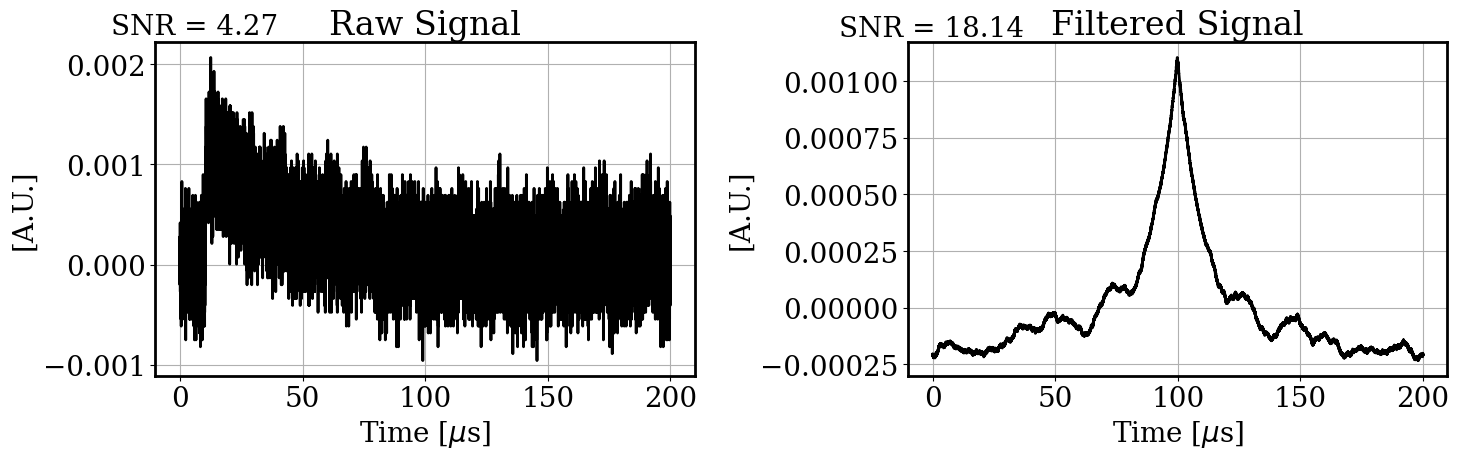

: 

In [32]:
#Guardo come cambiano i dati prima e dopo il filtro ottimo
nev = 10
#===================

x = np.linspace(0,len(signal_matrix[nev]),len(signal_matrix[nev]))
dev = signal_matrix[nev].std()
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(x*1e-2,signal_matrix[nev],linewidth=2,label='Data',color='black')
#axs[0].fill_between(x*1e-2,signal_matrix[nev]-dev,signal_matrix[nev]+dev,label=r'$\sigma$')
axs[0].grid()
axs[0].set_ylabel('[A.U.]')
axs[0].set_xlabel(r'Time [$\mu$s]')
axs[0].set_title('Raw Signal')


dev1 = signal_matrix_filtered_t.std()
axs[1].plot(x*1e-2,signal_matrix_filtered_t[nev],linewidth=2,label='Data',color='black')
#axs[1].fill_between(x*1e-2,signal_matrix_filtered_t[nev]-dev1,signal_matrix_filtered_t[nev]+dev1,label=r'$\sigma$')
axs[1].grid()
axs[1].set_ylabel('[A.U.]')
axs[1].set_xlabel(r'Time [$\mu$s]')
axs[1].set_title('Filtered Signal')
axs[0].text(-28,0.0023,'SNR = 4.27')
axs[1].text(-38,0.0012,'SNR = 18.14')

fig.tight_layout()

In [21]:
RMS_sig_bef = np.sqrt((1/signal_matrix.shape[0])*np.sum(signal_matrix**2)) 
RMS_sig_aft = np.sqrt((1/signal_matrix_filtered_t.shape[0])*np.sum(signal_matrix_filtered_t**2))

RMS_noise_bef = np.sqrt((1/noise_matrix.shape[0])*np.sum(noise_matrix**2)) 
RMS_noise_aft = np.sqrt((1/noise_matrix_filtered_t.shape[0])*np.sum(noise_matrix_filtered_t**2)) 

SNR_bef = 20*np.log10(RMS_sig_bef/RMS_noise_bef)
SNR_aft = 20*np.log10(RMS_sig_aft/RMS_noise_aft)

print(f'Before OF SNR = {SNR_bef}')
print(f'After  OF SNR = {SNR_aft}')

Before OF SNR = 4.273398081261951
After  OF SNR = 18.141587460428887


In [24]:
with open('Filter.txt','w') as f:
    for h in H:
        f.writelines(str(h.real)+'\t'+str(h.imag)+'\n')

# Applico il filtro ottimo per valutare l'ampiezza dei dati

In [25]:
batch_size = 500  # Tune this value according to your available memory
OFT, OFF, OFdelay, OFtest = applyOF(signal_matrix, H, batch_size=batch_size)

In [26]:
with open('OFF_Tension.txt','w') as f:
    for o in OFF:
        f.writelines(str(o)+'\n')

with open('OFT_Tension.txt','w') as f:
    for o in OFT:
        f.writelines(str(o)+'\n')

In [27]:
batch_size = 500  # Tune this value according to your available memory
OFT_noise, OFF_noise, OFdelay, OFtest = applyOF(noise_matrix, H, batch_size=batch_size)

In [31]:
OFT_noise.shape

(4124,)

In [32]:
np.sqrt(np.sum(OFT_noise[:300]**2))

np.float64(0.0015571740074798366)